In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [2]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load Fashion MNIST from OpenML
fashion = fetch_openml('Fashion-MNIST', version=1, as_frame=False)

X = fashion.data
y = fashion.target

# Normalize
X = X / 255.0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import time

start = time.time()
base_model = LogisticRegression(max_iter=10000)
base_model.fit(X_train, y_train)
train_time = time.time() - start

# Inference
start = time.time()
y_pred = base_model.predict(X_test)
inference_time = time.time() - start

print("Accuracy (no PCA):", accuracy_score(y_test, y_pred))
print("Training time (no PCA):", round(train_time, 2), "s")
print("Inference time (no PCA):", round(inference_time, 2), "s")


Accuracy (no PCA): 0.8527857142857143
Training time (no PCA): 231.5 s
Inference time (no PCA): 0.03 s


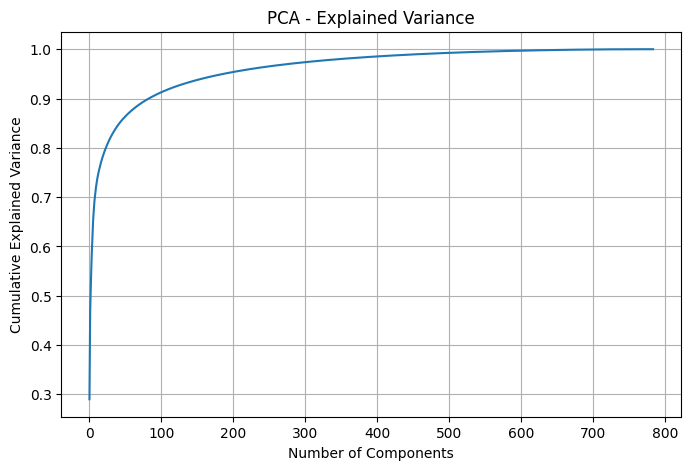

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA
pca = PCA().fit(X_train)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.show()


In [7]:
# Apply PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train model
start = time.time()
pca_model = LogisticRegression(max_iter=10000)
pca_model.fit(X_train_pca, y_train)
pca_train_time = time.time() - start

# Predict
start = time.time()
y_pred_pca = pca_model.predict(X_test_pca)
pca_inference_time = time.time() - start

print("Accuracy (with PCA):", accuracy_score(y_test, y_pred_pca))
print("Training time (PCA):", round(pca_train_time, 2), "s")
print("Inference time (PCA):", round(pca_inference_time, 2), "s")


Accuracy (with PCA): 0.8496428571428571
Training time (PCA): 40.26 s
Inference time (PCA): 0.0 s


In [8]:
comparison = pd.DataFrame({
    "Model": ["Baseline", "PCA (100 comps)"],
    "Accuracy": [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_pca)],
    "Training Time (s)": [train_time, pca_train_time],
    "Inference Time (s)": [inference_time, pca_inference_time]
})

print(comparison)


             Model  Accuracy  Training Time (s)  Inference Time (s)
0         Baseline  0.852786         231.500382            0.031101
1  PCA (100 comps)  0.849643          40.259792            0.004669


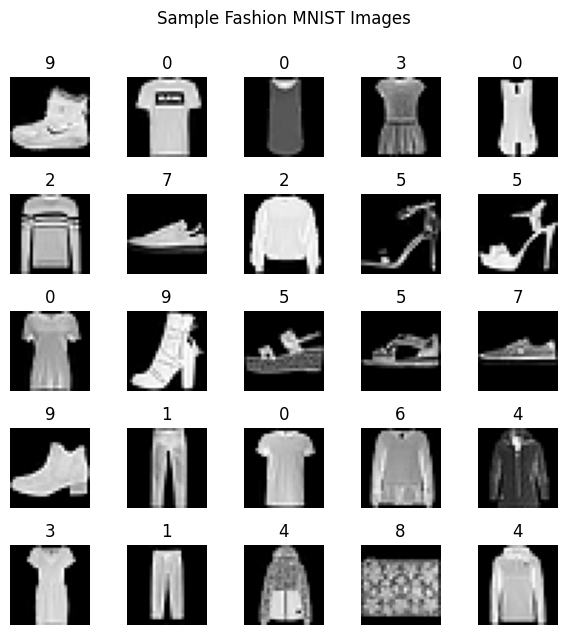

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(y[i])
    ax.axis('off')
plt.tight_layout()
plt.suptitle("Sample Fashion MNIST Images", y=1.05)
plt.show()


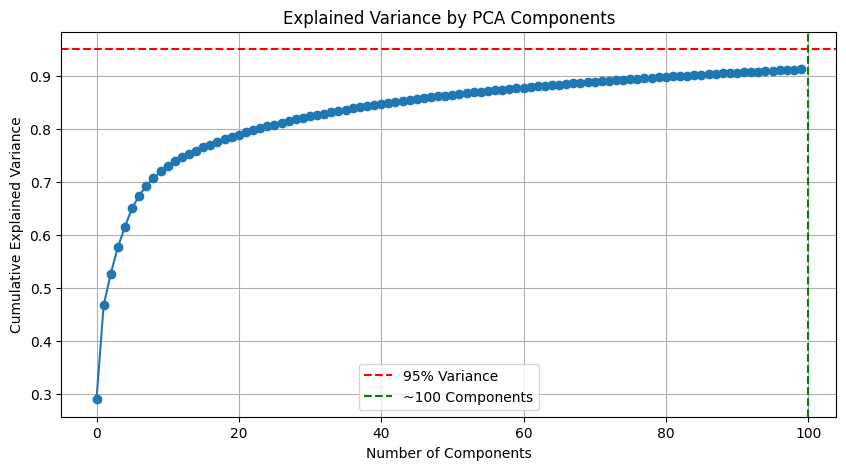

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axvline(x=100, color='g', linestyle='--', label='~100 Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.legend()
plt.grid(True)
plt.show()


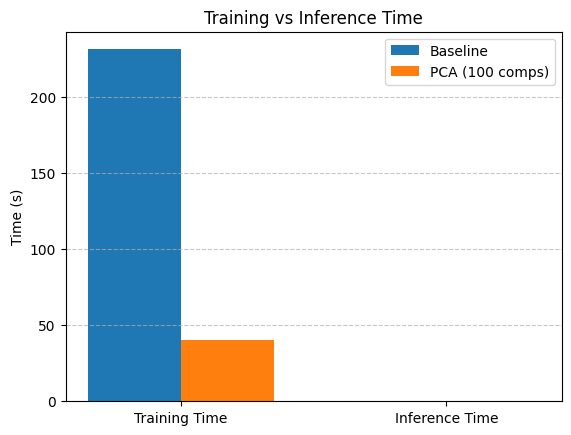

In [11]:
labels = ['Training Time', 'Inference Time']
baseline_times = [train_time, inference_time]
pca_times = [pca_train_time, pca_inference_time]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, baseline_times, width, label='Baseline')
ax.bar(x + width/2, pca_times, width, label='PCA (100 comps)')

ax.set_ylabel('Time (s)')
ax.set_title('Training vs Inference Time')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
